# Modèle de classement des textos en spam

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Exploratory-Data-Analysis-(EDA)" data-toc-modified-id="Exploratory-Data-Analysis-(EDA)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory Data Analysis (EDA)</a></span><ul class="toc-item"><li><span><a href="#Taille-des-messages" data-toc-modified-id="Taille-des-messages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Taille des messages</a></span></li><li><span><a href="#binarisation" data-toc-modified-id="binarisation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>binarisation</a></span></li></ul></li><li><span><a href="#nettoyage" data-toc-modified-id="nettoyage-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>nettoyage</a></span><ul class="toc-item"><li><span><a href="#fct-rm_punctuation" data-toc-modified-id="fct-rm_punctuation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>fct rm_punctuation</a></span></li><li><span><a href="#fc-tokenize" data-toc-modified-id="fc-tokenize-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>fc tokenize</a></span></li><li><span><a href="#fct-rm_stopwords" data-toc-modified-id="fct-rm_stopwords-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>fct rm_stopwords</a></span></li></ul></li><li><span><a href="#Liens" data-toc-modified-id="Liens-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Liens</a></span></li></ul></div>

Dans ce cas pratique on cherche à entraîner un modèle capable de prédire si un texto est un spam ou non. On s'appuie pour cela sur une base de données contenant des sms labellisés comme spam ou non spam (trouvée sur https://archive.ics.uci.edu/ml/datasets.php, voir readme pour plus d'informations).  

- Importez la base de données dans un dataframe 

- Appliquez les transformations usuelles du texte pour faciliter l'analyse textuelle

- Faites une matrice de termes et affichez les termes les plus fréquents dans chaque catégorie : spam ou non spam. Si nécessaire, enrichissez la liste de stop-words pour limiter la taille de la matrice.

- Faites un nuage de mots par catégorie pour bien illustrer les différences des mots utilisés entre spam et non spam.

- À partir de la matrice de termes réduite, entraînez un modèle de forêts aléatoires permettant de prédire si un texto est un spam ou non 

- Essayez d'améliorer la prédiction de votre modèle en ajoutant une analyse en composantes principales en amont.

On peut imaginer que pour une entreprise qui développe cette solution, on souhaite plus à minimiser l'erreur consistant à définir comme spam un texto qui n'en est pas un (erreur de type 1, "faux positif") plutôt que de rater quelques spams : 
- Utilisez votre dernier modèle pour prédire des probabilités que le texto soit un spam. À partir de quelle valeur de cette probabilité notre modèle ne classe aucun non spam en spam?

## Import

In [67]:
import pandas as pd
import re
import string

from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

from stop_words import get_stop_words

%matplotlib inline

In [45]:
data = pd.read_csv('data/SMSSpamCollection.txt', sep="\t", header=None, names=["cat", "sms"])

## Exploratory Data Analysis (EDA)

In [46]:
data.head(3)

,cat,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [58]:
len(data)

5572

In [47]:
data.dtypes

cat    object
sms    object
dtype: object

In [48]:
data.describe()

,cat,sms
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cat     5572 non-null   object
 1   sms     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [49]:
data.shape

(5572, 2)

In [50]:
data.columns

Index(['cat', 'sms'], dtype='object')

In [51]:
pd.crosstab(index=data["cat"],columns="count")

col_0,count
cat,
ham,4825
spam,747


In [74]:
sns.countplot(data)
plt.xlabel('Cat')
plt.title('Nb')

TypeError: len() of unsized object

In [60]:
data.groupby('cat').describe()

sms                                                               
     count unique                                                top freq
cat                                                                      
ham   4825   4514                             sorry  i ll call later   30
spam   747    631  private  your  account statement for shows  un...    4

### Taille des messages

In [61]:
data['length'] = data['sms'].apply(len)
data.head()

,cat,sms,length
0,ham,go until jurong point crazy available only ...,111
1,ham,ok lar joking wif u oni,29
2,spam,free entry in a wkly comp to win fa cup final...,130
3,ham,u dun say so early hor u c already then say,49
4,ham,nah i don t think he goes to usf he lives aro...,61


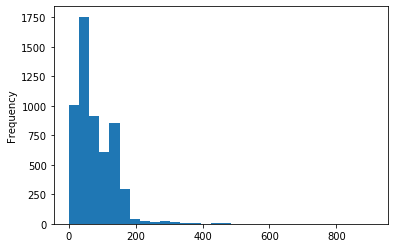

In [64]:
data['length'].plot(bins=30,kind = 'hist')

In [65]:
data['length'].describe()

count    5572.000000
mean       78.106066
std        57.813502
min         0.000000
25%        35.000000
50%        61.000000
75%       117.000000
max       910.000000
Name: length, dtype: float64

In [66]:
data[data['length'] == 910]['sms'].iloc[0]

'for me the love should start with attraction i should feel that i need her every time around me she should be the first thing which comes in my thoughts i would start the day and end it with her she should be there every time i dream love will be then when my every breath has her name my life should happen around her my life will be named to her i would cry for her will give all my happiness and take all her sorrows i will be ready to fight with anyone for her i will be in love when i will be doing the craziest things for her love will be when i don t have to proove anyone that my girl is the most beautiful lady on the whole planet i will always be singing praises for her love will be when i start up making chicken curry and end up makiing sambar life will be the most beautiful then will get every morning and thank god for the day because she is with me i would like to say a lot  will tell later  '

### binarisation

In [82]:
data['label_num'] = data.cat.map({'ham':0, 'spam':1})
data.head()

AttributeError: cat not found

## nettoyage

In [52]:
def premier_nettoyage(text):
    text = text.lower() # passage en minuscules
    text = re.sub(f"[{string.punctuation}]", " ", text) # on enlève la ponctuation  
    text = re.sub("[0-9]", "", text) # On enlève les références au minutages
    text = re.sub(r"\xa0", " ", text) # caractère spécial hypertexte
    return text

In [53]:
data["sms"] = data.sms.apply(lambda x: premier_nettoyage(x))

### fct rm_punctuation

In [81]:
def rm_punctuation(text):
    new_text=''.join([char for char in text if char not in string.punctuation])
    return new_text

In [95]:
data['new_text']=data['sms'].apply(lambda row : remove_punctuation(row))

IndexError: Index dimension must be <= 2

### fc tokenize

In [78]:
def tokenize(text):
    tokens=re.split('\W+',text)
    return tokens

In [94]:
data['tokenized_text']=data['new_text'].apply(lambda row : tokenize(row.lower()))
data.head()

IndexError: Index dimension must be <= 2

### fct rm_stopwords

In [91]:
eng_stop_words = get_stop_words('english')
#eng_stop_words
type(eng_stop_words)

list

In [92]:
STOPWORDS = eng_stop_words + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
type(STOPWORDS)

list

In [90]:
def rm_stopwords(text):
    clean_text = [word for word in text if word not in STOPWORDS]
    return clean_text 

In [93]:
data['clean_text']=data['tokenized_text'].apply(lambda row : rm_stopwords(row))

IndexError: Index dimension must be <= 2

In [54]:
data.shape, type(data)

((5572, 2), pandas.core.frame.DataFrame)

In [55]:
data.head(3)

,cat,sms
0,ham,go until jurong point crazy available only ...
1,ham,ok lar joking wif u oni
2,spam,free entry in a wkly comp to win fa cup final...


In [73]:
#data['sms'].iloc[0]

In [56]:
data.loc["spam"].values

KeyError: 'spam'

In [57]:
data.sms.loc["ham"]

KeyError: 'ham'

In [69]:
cv = CountVectorizer(stop_words = eng_stop_words)

In [71]:
data.sms

AttributeError: sms not found

In [70]:
data = cv.fit_transform(data.sms)
data_dtm = pd.DataFrame(data.toarray(), columns = cv.get_feature_names())
data_dtm.index = data.index
data_dtm

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


AttributeError: index not found

In [76]:
data_ham  = data[data['cat'] == 'spam'].copy()
data_spam = data[data['cat'] == 'spam'].copy()

IndexError: Index dimension must be <= 2